### One component mixture, 2D, independent variables

In [53]:
import sys
if "spnhelp" in sys.modules.keys():
    del sys.modules["spnhelp"]
import spnhelp
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
from spn.structure.Base import get_number_of_nodes, Product
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from spn.algorithms.Inference import likelihood
import clg
import math

[[1.         0.70710678]
 [0.70710678 1.        ]]


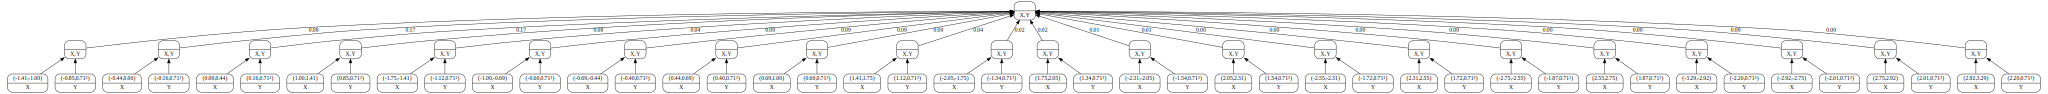

(100, 100)
0.7071067811865475
22


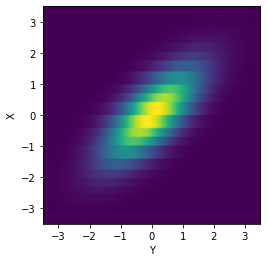

In [54]:
X = "X" @ clg.noise
a=0.5
Y = "Y" @ (math.sqrt(a)*X + math.sqrt(1-a)*clg.noise)
# display(X.get_graph(True))
print(X.get_Σ().to_numpy())
spn = spnhelp.clg_to_spn(X, crit_param=0.5, crit=spnhelp.CRIT_bounded_width, sloped=False)
# spnhelp.plot_marginals(spn, X)
display(spnhelp.get_spn_graph(spn, X))
info1 = spnhelp.get_pdf_grid_values(spn, (7, 7), offset = np.array([0, 0]), resolution=100, )
info2 = spnhelp.get_pdf_grid_values(spn, (7, 7), offset = np.array([0, 0]), resolution=100, pdf = lambda x : stats.multivariate_normal.pdf(x=x, mean = [0,0], cov=X.get_Σ().to_numpy()))
total = np.row_stack([info1[0], info2[0]])
total = info1[0]
print(total.shape)
spnhelp.show_data((total, (7, 7),  np.array([0, 0])))
print(1/math.sqrt(2))
print(get_number_of_nodes(spn, Product))

### 2 component mixture with sampling

array([[3.06504473, 0.17057328],
       [0.17057328, 0.74507702]])

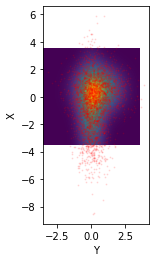

In [4]:
bump1 = Gaussian(mean=-1, stdev=2, scope=0) * Gaussian(mean=0, stdev=0.6, scope=1)
bump2 = Gaussian(mean=0.5, stdev=1, scope=0) * Gaussian(mean=0.5, stdev=1, scope=1)
spn = 0.5 * bump1 + 0.5 * bump2

info = spnhelp.get_pdf_grid_values(spn, (7, 7), np.array([0, 0]), 100)
spnhelp.show_data(info)


samples = spnhelp.sample_from_spn(spn, 4000)
plt.scatter(samples[:, 1], samples[:, 0], s=1, alpha=0.1, c = "red")

np.cov(samples, rowvar=False)

### Testing uniform density

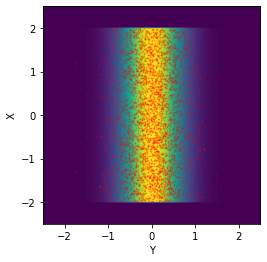

In [5]:
spn = Uniform(start=-2, end=2, scope=0) * Gaussian(mean=0, stdev=0.5, scope=1)
spn2 = Uniform(start=-2, end=2, scope=0) * Gaussian(mean=0, stdev=0.5, scope=1)
mix = 0.5 * spn + 0.5 * spn2
info = spnhelp.get_pdf_grid_values(mix, (5, 5), np.array([0, 0]), 100)
spnhelp.show_data(info)
samples = spnhelp.sample_from_spn(mix, 4000)
plt.scatter(samples[:, 1], samples[:, 0], s=1, alpha=0.2, c = "red");

# Approximating 1d gaussian with uniforms and slopyforms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


''

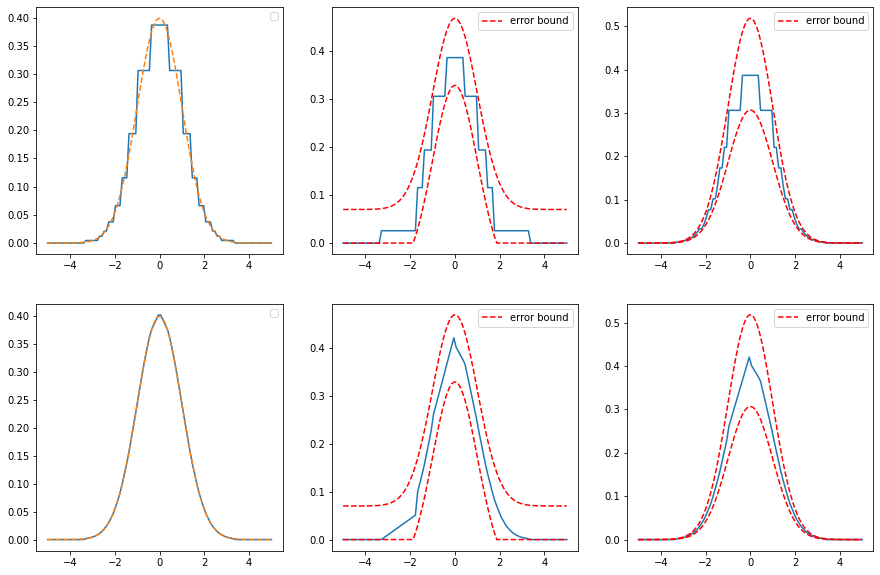

In [34]:

sd, mean = 1, 0
x = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(2,3, figsize=(15,10))

slopes = [False, False, False, True, True ,True]
criterions = [spnhelp.CRIT_bounded_width, spnhelp.CRIT_uniform_bounded_deviation, spnhelp.CRIT_uniform_bounded_ratio, spnhelp.CRIT_bounded_width, spnhelp.CRIT_slopyform_bounded_deviation, spnhelp.CRIT_slopyform_bounded_ratio]
crit_params = [0.7, 0.07, 1.3, 0.5, 0.07, 1.3]
ratio_bounds = [0.0, 0.0, 1.3] * 2
deviation_bounds = [0.0, 0.07, 0.0] * 2
for i, (slope, crit, crit_param,ratio_b, devia_b) in enumerate(zip(slopes, criterions, crit_params, ratio_bounds, deviation_bounds)):
    coords = int(i // (len(slopes)*0.5)), int(i % (len(slopes)*0.5))
    spn = spnhelp.clg_to_spn("A" @ (sd*clg.noise + mean), crit_param=crit_param, crit=crit, disc_leaves=True, sloped=slope)
    ax[coords].plot(x, likelihood(spn, x.reshape(-1, 1)))
    if ratio_b != 0:
        ax[coords].plot(x, stats.norm.pdf(x, loc=mean, scale=sd)*ratio_b, linestyle="dashed", c = "r", label = "error bound")
        ax[coords].plot(x, stats.norm.pdf(x, loc=mean, scale=sd)/ratio_b, linestyle="dashed", c = "r")
    elif devia_b != 0:
        ax[coords].plot(x, np.maximum(0, stats.norm.pdf(x, loc=mean, scale=sd) + devia_b), linestyle="dashed", c = "r", label = "error bound")
        ax[coords].plot(x, np.maximum(0, stats.norm.pdf(x, loc=mean, scale=sd) - devia_b), linestyle="dashed", c = "r")
    else:
        ax[coords].plot(x, stats.norm.pdf(x, loc=mean, scale=sd), linestyle="dashed")
    ax[coords].legend()
;

# Same, but 2d independent gaussians

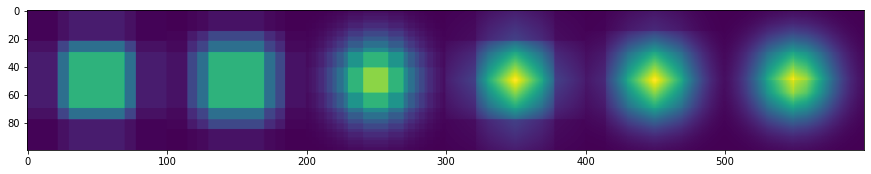

In [51]:
plt.rcParams["figure.figsize"] = (15, 10)



A = "A" @ clg.noise
B = "B" @ clg.noise
A & B


slopes = [False, False, False, True, True ,True]
criterions = [spnhelp.CRIT_bounded_width, spnhelp.CRIT_uniform_bounded_deviation, spnhelp.CRIT_uniform_bounded_ratio, spnhelp.CRIT_bounded_width, spnhelp.CRIT_slopyform_bounded_deviation, spnhelp.CRIT_slopyform_bounded_ratio]
crit_params = [2.0, 0.1, 1.3] * 2
ratio_bounds = [0.0, 0.0, crit_params[2]] * 2
deviation_bounds = [0.0, crit_params[1], 0.0] * 2

heatmaps = []
for i, (slope, crit, crit_param,ratio_b, devia_b) in enumerate(zip(slopes, criterions, crit_params, ratio_bounds, deviation_bounds)):
    spn = spnhelp.clg_to_spn(A, crit_param=crit_param, crit=crit, disc_leaves=True, sloped=slope)
    vals, _, _ = spnhelp.get_pdf_grid_values(spn, (5, 5), np.array([0, 0]), 100)
    heatmaps.append(vals)
heatmaps = np.array(heatmaps)

plt.imshow(np.reshape(heatmaps, (-1, 100)).T);

# Again same, but 2d dependent gaussians this time

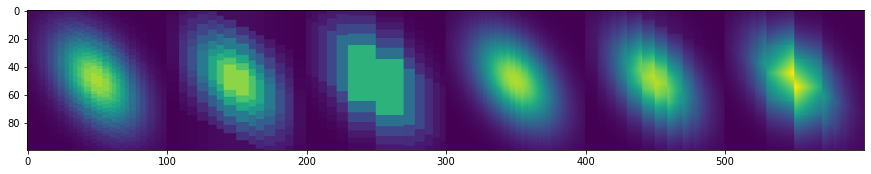

In [55]:
plt.rcParams["figure.figsize"] = (15, 10)


A = "A" @ clg.noise
B = "B" @ (0.5*A + clg.noise)


slopes = [False, False, False, True, True ,True]
criterions = [spnhelp.CRIT_bounded_width, spnhelp.CRIT_uniform_bounded_deviation, spnhelp.CRIT_uniform_bounded_ratio, spnhelp.CRIT_bounded_width, spnhelp.CRIT_slopyform_bounded_deviation, spnhelp.CRIT_slopyform_bounded_ratio]
crit_params = [0.25, 0.05, 1.5] * 2
ratio_bounds = [0.0, 0.0, crit_params[2]] * 2
deviation_bounds = [0.0, crit_params[1], 0.0] * 2

heatmaps = []
for i, (slope, crit, crit_param,ratio_b, devia_b) in enumerate(zip(slopes, criterions, crit_params, ratio_bounds, deviation_bounds)):
    spn = spnhelp.clg_to_spn(A, crit_param=crit_param, crit=crit, disc_leaves=True, sloped=slope)
    vals, _, _ = spnhelp.get_pdf_grid_values(spn, (5, 5), np.array([0, 0]), 100)
    heatmaps.append(vals)
heatmaps = np.array(heatmaps)

plt.imshow(np.reshape(heatmaps, (-1, 100)).T);

### Computing Expectations (had to implement uniform moments)

In [ ]:
from spn.algorithms.stats.Moments import Moment, get_variance, get_mean

print (get_mean(uniform_spn)) # mean
print (get_variance(uniform_spn)) # variance

[[1.82145965e-16 1.82145965e-16]]
[[1.69641893 1.69641893]]
